## Setup

In [4]:
%%javascript
MathJax.Hub.Config({
      TeX: { equationNumbers: { autoNumber: "AMS" } }
    });MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

In [5]:
from math import exp
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Introduction

This notebook will demonstrate how to use the code in the `nnode1.py` module. The module allows the user to solve 1st-order ordinary differential equation (ODE) initial value problems (IVPs) using a single-hidden layer neural network.

This work is based on the paper ["Artificial Neural Networks for Solving Ordinary and Partial Differential Equations", by Lagaris et al, *IEEE Transactions on Neural Networks, Volume 9, No. 5*, September 1998](http://ieeexplore.ieee.org/document/712178/). Note that the notation used in this notebook and the associated Python code code is slightly different from that used in the Lagaris paper.

## The algorithm

Any 1st-order ODE can be written in the form:

\begin{equation}
\frac {dy}{dx} = f(x,y)
\end{equation}

The problem is to find a suitable solution to the ODE using a neural network.

The network is trained using a set of training points, defined on the domain of interest. The training points need not be evenly-spaced. Note that only the independent variable values $x_i$ of the training points are needed - the estimated value of the solution at those training points is obtained using a trial solution. For 1st-order ODE IVP, the trial solution has the form:

\begin{equation}
y_t(x_i) = A + x_i N(x_i)
\end{equation}

or:

\begin{equation}
y_{ti} = A + x_i N_i
\end{equation}

where $y_{ti}=y_t(x_i)$ is the value of the trial solution at the current training point $x_i$, $A$ is the initial condition ($y(0)$), and $N_i=N(x_i
)$ is the single-valued floating-point output from an unspecified neural network. Note that this trial solution satisfies the initial condition by construction - at $x=0$, the second term vanishes, leaving $y_t(0)=A$, which is just the specified initial condition.

Training is done in a set of *epochs*. A training epoch consists of presenting the neural network with each of the $n$ training points $x_i$, one at a time. For each input value $x_i$, the network output $N_i$ is computed. Once all $n$ points have been presented, the epoch is complete, and the error function $E$ is computed. Since the problem definition (1) provides an analytical form $f(x,y)$ for the derivative of the solution $y(x)$, the appropriate error function is the sum of squared errors (SSE):

\begin{equation}
E = \sum_{j=1}^{n}\left(\frac{\partial y_{ti}}{\partial x_i}-f_i\right)^2
\end{equation}

where ${\partial y_{ti}}/{\partial x_i}$ is the derivative of the trial function with respect to $x$, evaluated at $x_i$. This derivative is an approximation of the analytical derivative $f_i = f(x_i,y_{ti})$, with $y_{ti}$ used in place of $y$. Once this error function is computed, the weights and biases in the neural network are adjusted to reduce the error. Eventually, a minimum of $E$ is attained, and the resulting final form of $y_t(x)$ is used as the solution to the original ODE.

## Computing the network output $N_i$

The neural network used in this work has a simple structure. A single input node is used to provide the training data. The input node is fully-connected to a set of $H$ hidden nodes. Each hidden node is connected to a single output node, which uses a linear transfer function with a weight for the signal from each hidden node.

During each step of a training epoch, the input to the network, and thus the output of the single input node, is just the training point $x_i$. This single output is then sent to each of the $H$ hidden nodes. At each hidden node, the input value $x_i$ is scaled by the equation:

\begin{equation}
z_{ij} = w_jx_i + u_j
\end{equation}

where $z_{ij}$ is the scaled value of $x_i$ at hidden node $j$, $w_j$ is the weight at node $j$, and $u_j$ is the bias at node $j$. This scaled value is then used as the input to a sigmoidal transfer function:

\begin{equation}
\sigma_{ij} = \sigma(z_{ij})
\end{equation}

where:

\begin{equation}
\sigma(z) = \frac {1}{1+e^{-z}}
\end{equation}

A plot of this transfer function and its first several derivatives is provided below.

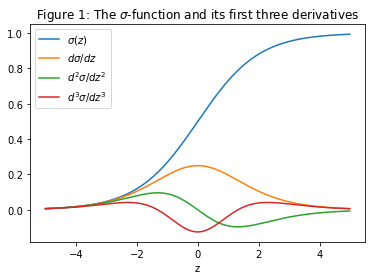

In [9]:
def sigma(z):
    return 1 / (1 + exp(-z))

def dsigma_dz(z):
    return exp(-z) / (1 + exp(-z))**2

def d2sigma_dz2(z):
    return (
        2 * exp(-2 * z) / (1 + exp(-z))**3 - exp(-z) / (1 + exp(-z))**2
    )

def d3sigma_dz3(z):
    return (
        6 * exp(-3 * z) / (1 + exp(-z))**4
        - 6 * exp(-2 * z) / (1 + exp(-z))**3
        + exp(-z) / (1 + exp(-z))**2
    )

z = np.arange(-5, 5, 0.01)
n = len(z)
s = np.zeros(n)
ds_dz = np.zeros(n)
d2s_dz2 = np.zeros(n)
d3s_dz3 = np.zeros(n)
for i in range(n):
    s[i] = sigma(z[i])
    ds_dz[i] = dsigma_dz(z[i])
    d2s_dz2[i] = d2sigma_dz2(z[i])
    d3s_dz3[i] = d3sigma_dz3(z[i])
plt.plot(z,s,label = "$\sigma(z)$")
plt.plot(z,ds_dz,label = "$d\sigma/dz$")
plt.plot(z,d2s_dz2, label = "$d^2\sigma/dz^2$")
plt.plot(z,d3s_dz3, label = "$d^3\sigma/dz^3$");
plt.xlabel("z")
#plt.ylabel("s(z) or derivative")
plt.title("Figure 1: The $\sigma$-function and its first three derivatives")
plt.legend();

Once the $\sigma_{ij}$ are computed, they are all passed to the single output node, where they are summed by a linear transfer function to create the network output for the current value of $x_i$:

\begin{equation}
N_i = \sum_{j=1}^{H}v_j\sigma_{ij}
\end{equation}

where $v_j$ is the weight applied to hidden node $j$ at the output node. Once $N_i$ has been computed, the trial function $y_{ti}$ is computed (3), and then the value of the ODE $f_i$ is computed (1). We then compute the derivative of the trial function to use in the error computation:

\begin{equation}
\frac{\partial y_{ti}}{\partial x_i} = x_i \frac {\partial N_i}{\partial x_i} + N_i
\end{equation}

The value of the network derivative $\frac {\partial N_I}{\partial x_i}$ is computed analytically using the known form of the network and its weights and biases.

\begin{equation}
\frac {\partial N_i}{\partial x_i} =
\frac {\partial}{\partial x_i} \sum_{j=1}^{H} v_j \sigma_{ij} =
\sum_{j=1}^{H} v_j \frac {\partial \sigma_{ij}}{\partial x_i} = \sum_{j=1}^{H} v_j \frac {\partial \sigma_{ij}}{\partial z_{ij}} \frac {\partial z_{ij}}{\partial x_i} = \sum_{j=1}^{H} v_j w_j \sigma_{ij}^{(1)}
\end{equation}

where the derivatives of $\sigma$ are given by:

\begin{equation}
\sigma^{(k)} = \frac {d^k \sigma}{dz^k}
\end{equation}

We now have all the values we need to compute the error function $E$ for the current epoch (4).

## Updating the network parameters

The network parameters are the weights and biases of the hidden and output nodes. For a set of $H$ hidden nodes, we have a total of $N_p = 3H$ parameters in total: a weight and bias for each hidden node, and an output weight for each hidden node.

Since the objective function to minimize is the error $E$, the value of each network parameter $p_j$ (where $p_j$ represents $v_j$, $u_j$, or $w_j$) is updated using a scaled Newton's method:

\begin{equation}
p_{j,new}=p_j - \eta \frac {\frac {\partial E}{\partial {p_j}}} {\frac {\partial^2 E}{\partial {p_j^2}}}
\end{equation}

where $\eta$ is the *learning rate* (usually $\alpha < 1$). The learning rate is used to reduce the chance of solution instability due to large values of the numerator, or small values of the denominator, in (12). The derivatives of $E$ are computed from (4) using the known form of the network and internal parameters.

This process of parameter updates is repeated until convergence is achieved (an error minimum is reached), or until the specified maximum number of training epochs have been applied. Note that the same set of training points is presented during each epoch.

## Computing the derivatives of $E$

The first partial derivative of $E$ with respect to any network parameter $p_j$ is given by:

\begin{equation}
\frac {\partial E}{\partial p_j} = \frac {\partial}{\partial p_j} \sum_{i=1}^{n}(\frac{\partial y_{ti}}{\partial x_i}-f_i)^2 = 2 \sum_{i=1}^n (\frac {\partial y_{ti}}{\partial x_i} - f_i)(\frac {\partial^2 y_{ti}}{\partial p_j \partial x_i} - \frac {\partial f_i}{\partial p_j})
\end{equation}

This expression requires the first partial derivatives of $\frac {\partial y_{ti}}{\partial x_i}$ and $f_i$ with respect to the network parameters.

The second partial derivative of $E$ with respect to any network parameter $p_j$ is given by:

\begin{equation}
\frac {\partial^2 E}{\partial p_j^2} = \frac {\partial}{\partial p_j} 2 \sum_{i=1}^n (\frac {\partial y_{ti}}{\partial x_i} - f_i)(\frac {\partial^2 y_{ti}}{\partial p_j \partial x_i} - \frac {\partial f_i}{\partial p_j}) = 2 \sum_{i=1}^n [(\frac {\partial y_{ti}}{\partial x_i} - f_i)(\frac {\partial^3 y_{ti}}{\partial p_j^2 \partial x_i} - \frac {\partial^2 f_i}{\partial p_j^2}) + (\frac {\partial^2 y_{ti}}{\partial p_j \partial x_i} - \frac {\partial f_i}{\partial p_j})^2]
\end{equation}

This expression requires the second partial derivatives of $\frac {\partial y_{ti}}{\partial x_i}$ and $f_i$ with respect to the network parameters.

The general forms of the partial derivatives of $\frac {\partial y_{ti}}{\partial x_i}$ are:

\begin{equation}
\frac {\partial^2 y_{ti}}{\partial p_j \partial x_i} = \frac {\partial}{\partial p_j} (x_i \frac {\partial N_i}{\partial x_i} + N_i) = x_i \frac {\partial^2 N_i}{\partial p_j \partial x_i} + \frac {\partial N_i}{\partial p_j}
\end{equation}

\begin{equation}
\frac {\partial^3 y_{ti}}{\partial p_j^2 \partial x_i} = \frac {\partial}{\partial p_j} (x_i \frac {\partial^2 N_i}{\partial p_j \partial x_i} + \frac {\partial N_i}{\partial p_j}) = x_i \frac {\partial^3 N_i}{\partial p_j^2 \partial x_i} + \frac {\partial^2 N_i}{\partial p_j^2}
\end{equation}

The partial derivatives of $N_i$ with respect to the network parameters are (note that terms $j \neq k$ vanish):

\begin{equation}
\frac {\partial N_i}{\partial p_j} = \frac {\partial}{\partial p_j} \sum_{k=1}^H v_k \sigma_{ik} = v_j \frac {\partial \sigma_{ij}}{\partial p_j} + \frac {\partial v_j}{\partial p_j} \sigma_{ij} = v_j \sigma_{ij}^{(1)}\frac {\partial z_{ij}}{\partial p_j} + \frac {\partial v_j}{\partial p_j}\sigma_{ij}
\end{equation}

\begin{equation}
\frac {\partial^2 N_i}{\partial p_j^2} = \frac {\partial}{\partial p_j} (v_j \sigma_{ij}^{(1)}\frac {\partial z_{ij}}{\partial p_j} + \frac {\partial v_j}{\partial p_j}\sigma_{ij}) = v_j \sigma_{ij}^{(2)} (\frac {\partial z_{ij}}{\partial p_j})^2 + \frac {\partial v_j}{\partial p_j} \sigma_{ij}^{(1)} \frac {\partial z_{ij}}{\partial p_j} + \frac {\partial v_j}{\partial p_j} \sigma_{ij}^{(1)} \frac {\partial z_{ij}}{\partial p_j} + \frac {\partial^2 v_j}{\partial p_j^2} \sigma_{ij}
\end{equation}

The partial derivatives of $f_i$ with respect to the network parameters are:

\begin{equation}
\frac{\partial f_i}{\partial p_j} = \frac{\partial f_i}{\partial y_{ti}} \frac{\partial y_{ti}}{\partial p_j}
\end{equation}

\begin{equation}
\frac{\partial^2 f_i}{\partial p_j^2} = \frac{\partial f_i}{\partial y_{ti}} \frac{\partial^2 y_{ti}}{\partial p_j^2} + \frac{\partial^2 f_i}{\partial y_{ti}^2} (\frac{\partial^2 y_{ti}}{\partial p_j^2})^2
\end{equation}

The definitions of $\frac {\partial f_i}{\partial y_{ti}}$ and $\frac {\partial^2 f_i}{\partial y_{ti}^2}$ are obtained using (1).

We now need the cross-partials of $N_i$ with respect to $x_i$ and the network parameters $p_j$. Again, the terms $j \neq k$ vanish.

\begin{equation}
\begin{split}
\frac {\partial^2 N_i}{\partial p_j \partial x_i} = \frac {\partial}{\partial p_j} (\sum_{k=1}^{H} v_k w_k \sigma_{ik}^{(1)}) = v_j w_j \sigma_{ij}^{(2)} \frac {\partial z_{ij}}{\partial p_j} + v_j \frac {\partial w_j}{\partial p_j} \sigma_{ij}^{(1)} + \frac {\partial v_j}{\partial p_j} w_j \sigma_{ij}^{(1)}
\end{split}
\end{equation}

\begin{equation}
\frac {\partial^3 N_i}{\partial p_j^2 \partial x_i} = \frac {\partial}{\partial p_j} (v_j w_j \sigma_{ij}^{(2)} \frac {\partial z_{ij}}{\partial p_j} + v_j \frac {\partial w_j}{\partial p_j} \sigma_{ij}^{(1)} + \frac {\partial v_j}{\partial p_j} w_j \sigma_{ij}^{(1)}) \\
= v_j w_j \sigma_{ij}^{(2)} \frac {\partial^2 z_{ij}}{\partial p_j^2} + v_j w_j \sigma_{ij}^{(3)} (\frac {\partial z_i}{\partial p_j})^2 + v_j \frac {\partial w_j}{\partial p_j} \sigma_{ij}^{(2)} \frac {\partial z_{ij}}{\partial p_j} + \frac {\partial v_j}{\partial p_j} w_j \sigma_{ij}^{(2)} \frac {\partial z_{ij}}{\partial p_j} \\
+ v_j \frac {\partial w_j}{\partial p_j} \sigma_{ij}^{(2)} \frac {\partial z_{ij}}{\partial p_j} + v_j \frac {\partial^2 w_j}{\partial p_j^2} \sigma_{ij}^{(1)} + \frac {\partial v_j}{\partial p_j} \frac {\partial w_j}{\partial p_j} \sigma_{ij}^{(1)} \\
+ \frac {\partial v_j}{\partial p_j} w_j \sigma_{ij}^{(2)} \frac {\partial z_{ij}}{\partial p_j} + \frac {\partial v_j}{\partial p_j} \frac {\partial w_j}{\partial p_j} \sigma_{ij}^{(1)} + \frac {\partial^2 v_j}{\partial p_j^2} w_j \sigma_{ij}^{(1)}
\end{equation}

Most of these expressions can now be simplified using the following relations between the network parameters:

\begin{equation}
\frac {\partial p_j}{\partial p_k} = \delta_{jk}
\end{equation}


\begin{equation}
\frac {\partial^2 p_j}{\partial p_k^2} = 0
\end{equation}

\begin{equation}
\frac {\partial z_{ij}}{\partial v_j} = 0
\end{equation}

\begin{equation}
\frac {\partial z_{ij}}{\partial u_j} = 1
\end{equation}

\begin{equation}
\frac {\partial z_{ij}}{\partial w_j} = x_i
\end{equation}

# Walking through an example problem

We will now walk through a complete problem which will illustrate how to use the nnode1 code to solve a 1st-order ODE IVP.

## Define the ODE to solve

Consider the simple 1st-order ODE, defined on the range $x=[0, 1]$:

\begin{equation}
\frac {dy}{dx} + x y = x
\end{equation}

This can be rearranged into the standard form (1):

\begin{equation}
\frac {dy}{dx} = f(x,y) = x(1-y)
\end{equation}

The analytical solution to this equation is:

\begin{equation}
y(x) = 1 + e^{-x^2/2}
\end{equation}

The analytical solution and its derivative are shown in the figure below.

In [10]:
def ya(x):
    return 1 + exp(-x**2 / 2)

# Define the 1st analytical derivative.
def dya_dx(x):
    return -x * exp(-x**2 / 2)

# Define the original differential equation:
def F(x, y):
    return x * (1 - y)

# Define the 1st y-partial derivative of the differential equation.
def dF_dy(x, y):
    return -x

# Define the 2nd y-partial derivative of the differential equation.
def d2F_dy2(x, y):
    return 0

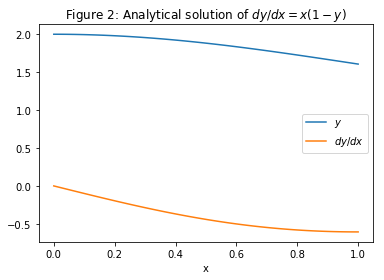

In [18]:
xmin = 0
xmax = 1
n = 100
dx = (xmax - xmin) / n
#x = np.arange(xmin, xmax, dx) # Give division by zero error
x = np.linspace(xmin,xmax,n)
y = np.zeros(n)
dy_dx = np.zeros(n)
for i in range(n):
    y[i] = ya(x[i])
    dy_dx[i] = dya_dx(x[i])
plt.plot(x, y, label = "$y$")
plt.plot(x, dy_dx, label = "$dy/dx$")
plt.xlabel("x")
#plt.ylabel("$d^ky/dx^k$")
plt.legend()
plt.title("Figure 2: Analytical solution of $dy/dx = x(1-y)$");

## Other required definitions

The code above also defines several derivative functions that are required for computation of the gradients by the neural network. In addition to the ODE itself (defined as the function F), the first two partial derivatives of the ODE function $f(x,y)$ with respect to $y$ are required (defined as the functions `dF_dy` and `d2F_dy2`).

## Define the boundary conditions

Boundary conditions for the ODE must be set before the solution is attempted. For 1st-order ODE BVP, only Dirichlet boundary conditions (BC) are possible. In this case, we will always use the value of $y_t(0)$, denoted as $A$. For this problem, we are interested in a solution over the range $x=[0,1]$. The boundary conditions are therefore:

\begin{equation}
x_{min} = 0 \\
x_{max} = 1 \\
A = y(0) = 2
\end{equation}


## Create the training data

For the purposes of this example, an evenly-spaced set of training points will be used to train the neural network. Note that the initial point ($y_t(0)=A$) is not included in the training set, as it would artificially improve the accuracy measures of the solution.

In [22]:
nt = 10
dx = (xmax - xmin) / nt
xt = np.linspace(xmin,xmax,nt)
#xt = np.arange(xmin, xmax, dx) + dx

Note that repeated runs of the same ODE will usually result in slightly different solutions, due to the random number generator. To ensure repeatable results, seed the random number generator with a fixed value before each run.

## Train the model to solve the ODE

We can now train the network. The call below shows the minimum arguments required to call the nnode1() function. All tunable parameters (learning rate, hidden layer size, number of training epochs) are given default values (0.01, 10, 1000, respectively). The training function returns the computed values of $y$ and $\frac {dy}{dx}$ at the training points.

In [25]:
from nnode1 import nnode1
A = ya(xmin)
np.random.seed(0)
(yt, dyt_dx) = nnode1(xt, F, dF_dy, d2F_dy2, A)

Plot the results of this training run.

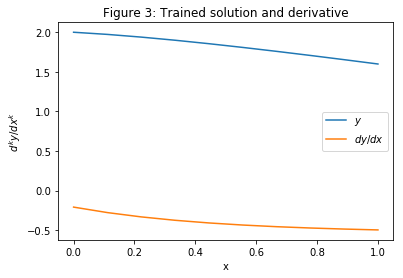

In [24]:
plt.plot(xt, yt, label = "$y$")
plt.plot(xt, dyt_dx, label = "$dy/dx$")
plt.xlabel("x")
plt.ylabel("$d^ky/dx^k$")
plt.legend()
plt.title("Figure 3: Trained solution and derivative");

Plot the error in the estimated solution and derivative.

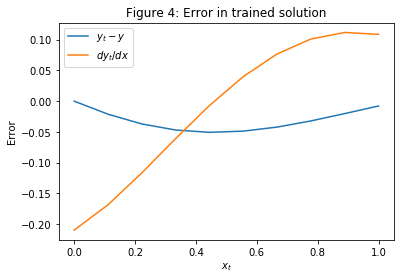

In [26]:
y = np.zeros(nt)
dy_dx = np.zeros(nt)
for i in range(nt):
    y[i] = ya(xt[i])
    dy_dx[i] = dya_dx(xt[i])
plt.plot(xt, yt - y, label = "$y_t-y$")
plt.plot(xt, dyt_dx - dy_dx, label = "$dy_t/dx$")
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 4: Error in trained solution");

Now try repeating the analysis with a larger number of hidden nodes, and plot the error.

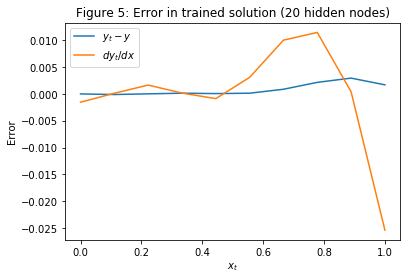

In [27]:
np.random.seed(0)
(yt, dyt_dx) = nnode1(xt, F, dF_dy, d2F_dy2, A, nhid = 20)
y = np.zeros(nt)
dy_dx = np.zeros(nt)
for i in range(nt):
    y[i] = ya(xt[i])
    dy_dx[i] = dya_dx(xt[i])
plt.plot(xt, yt - y, label = "$y_t-y$")
plt.plot(xt, dyt_dx - dy_dx, label = "$dy_t/dx$")
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 5: Error in trained solution (20 hidden nodes)");

Now try repeating the analysis with a slightly larger learning rate, and plot the error.

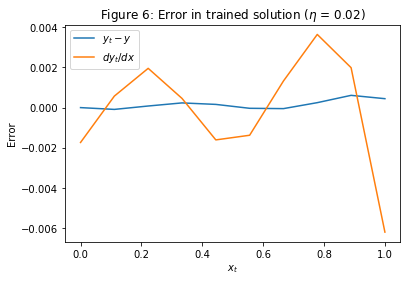

In [28]:
np.random.seed(0)
(yt, dyt_dx) = nnode1(xt, F, dF_dy, d2F_dy2, A, eta = 0.02)
y = np.zeros(nt)
dy_dx = np.zeros(nt)
for i in range(nt):
    y[i] = ya(xt[i])
    dy_dx[i] = dya_dx(xt[i])
plt.plot(xt, yt - y, label = "$y_t-y$")
plt.plot(xt, dyt_dx - dy_dx, label = "$dy_t/dx$")
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 6: Error in trained solution ($\eta$ = 0.02)");

Now try repeating the analysis with a larger number of training epochs, and plot the error.

In [ ]:
np.random.seed(0)
(yt, dyt_dx) = nnode1(xt, F, dF_dy, d2F_dy2, A, maxepochs = 2000)
y = np.zeros(nt)
dy_dx = np.zeros(nt)
for i in range(nt):
    y[i] = ya(xt[i])
    dy_dx[i] = dya_dx(xt[i])
plt.plot(xt, yt - y, label = "$y_t-y$")
plt.plot(xt, dyt_dx - dy_dx, label = "$dy_t/dx$")
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 7: Error in trained solution (2000 epochs)");

## Using a ODE definition module

Rather than entering ODE definitions in this notebook, the required definitions can be entered in a separate Python module, and imported. For example, the previous code is also encapsulated in the module ode00.py, and can be imported:

In [ ]:
import ode00

We can now run the net using the information in this module.

In [ ]:
np.random.seed(0)
(yt, dyt_dx) = nnode1(xt, ode00.F, ode00.dF_dy, ode00.d2F_dy2, ode00.ymin)
y = np.zeros(nt)
dy_dx = np.zeros(nt)
for i in range(nt):
    y[i] = ode00.ya(xt[i])
    dy_dx[i] = ode00.dya_dx(xt[i])
plt.plot(xt, yt - y, label = "$y_t-y$")
plt.plot(xt, dyt_dx - dy_dx, label = "$dy_t/dx$")
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 8: Error in trained solution (using ode00.py)");

Other examples of 1st-order ODEs from the Lagaris paper have been provided in the files lagaris01.py and lagaris02.py. Run them in the same fashion.

In [ ]:
np.random.seed(0)
import lagaris01
(yt, dyt_dx) = nnode1(xt, lagaris01.F, lagaris01.dF_dy,
                      lagaris01.d2F_dy2, lagaris01.ymin, nhid = 40)
y = np.zeros(nt)
dy_dx = np.zeros(nt)
for i in range(nt):
    y[i] = lagaris01.ya(xt[i])
    dy_dx[i] = lagaris01.dya_dx(xt[i])
plt.plot(xt, yt - y, label = "$y_t-y$")
plt.plot(xt, dyt_dx - dy_dx, label = "$dy_t/dx$")
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 9: Error in trained solution (using lagaris01.py)");

In [ ]:
np.random.seed(0)
import lagaris02
(yt, dyt_dx) = nnode1(xt, lagaris02.F, lagaris02.dF_dy, lagaris02.d2F_dy2,
                      lagaris02.ymin, nhid = 40)
y = np.zeros(nt)
dy_dx = np.zeros(nt)
for i in range(nt):
    y[i] = lagaris02.ya(xt[i])
    dy_dx[i] = lagaris02.dya_dx(xt[i])
plt.plot(xt, yt - y, label = "$y_t-y$")
plt.plot(xt, dyt_dx - dy_dx, label = "$dy_t/dx - dy/dx$")
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 10: Error in trained solution (using lagaris02.py)");